In [8]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import math

In [2]:
with open ('matrix/vocab_idx_map.pkl', 'rb') as f1:
    vocab_idx_meta = pickle.load(f1)
with open('matrix/idx_vocab_map.pkl', 'rb') as f2:
    idx_vocab_meta = pickle.load(f2)
with open('matrix/patient_idx_map.pkl', 'rb') as f3:
    patient_idx_meta = pickle.load(f3)
with open('matrix/idx_patient_map.pkl', 'rb') as f4:
    idx_patient_meta = pickle.load(f4)
with open('matrix/phecode_list.pkl', 'rb') as f5:
    PheCode = pickle.load(f5)

phi_mtx_path = 'Results/phi_mtx_iter5.pkl'
theta_mtx_path = 'Results/theta_mtx_iter5.pkl' 

with open(phi_mtx_path, 'rb') as f:
    phi = pickle.load(f)
with open(theta_mtx_path, 'rb') as f:
    theta = pickle.load(f)

In [3]:
phi.shape

(4923, 6239)

In [4]:
ICD_meta = pd.read_csv("D_ICD_DIAGNOSES.csv.gz", header=0)
ICD_meta = ICD_meta[['ICD9_CODE','SHORT_TITLE']]
ICD_meta['ICD9_CODE'] = ICD_meta['ICD9_CODE'].str.lstrip('0')
ICD_meta['Compound_ID'] = ICD_meta['ICD9_CODE'] + "-" + ICD_meta['SHORT_TITLE']

ICD_topic_prob = phi.T
ICD_list = list(range(ICD_topic_prob.shape[0]))
ICD_code_list = [idx_vocab_meta[key] for key in ICD_list]
vocab = []   
for key in ICD_code_list:
    value = ICD_meta[ICD_meta['ICD9_CODE'] == str(key).replace('.','')]['Compound_ID'].tolist()
    if value == []:
        value = [str(key)] 
    vocab.append(value[0])

In [5]:
pearson_correlation = []
with tqdm (total = int(4923/3)) as pbar:
    for i in range(int(4923/3)):
        top_icd_idx = []
        top_ICD_topic = []
        sorted_idx = np.argsort(-phi.T[:,i*3:(i*3+3)], axis=0)
        for k in range(3):
            sorted_index_k = sorted_idx[:, k] 
            for idx, ICD in enumerate(sorted_index_k[:3]): 
                top_icd_idx.append(ICD) 
#         print(phi.T[top_icd_idx,i*3:(i*3 + 3)])
        tmp = pd.DataFrame(phi.T[top_icd_idx,i*3:(i*3 + 3)]).corr()       
        pearson_corr = (tmp.loc[0,1] + tmp.loc[0,2] + tmp.loc[1,2])/3
        pearson_correlation.append(pearson_corr)
        pbar.update(1)

100%|█████████████████████████████████████| 1641/1641 [00:01<00:00, 1453.91it/s]


In [69]:
tmp = pearson_correlation.sort()

In [84]:
np.argsort(pearson_correlation, axis=0)[:10]

array([   1,   10,  318, 1623,  154, 1542, 1578,  981, 1629, 1426])

In [86]:
selected_phecode = [PheCode[i] for i in [   1,   10,  318, 1623,  154, 1542, 1578,  981, 1629, 1426]]

In [87]:
selected_phecode

[8.5, 38.1, 276.5, 1000.0, 204.0, 860.0, 952.0, 565.0, 1006.0, 751.2]

In [9]:
remove_na = [0 if math.isnan(x) else x for x in pearson_correlation]

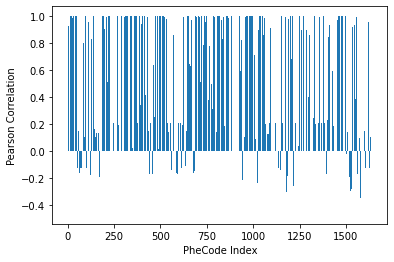

In [17]:
import matplotlib.pyplot as plt
plt.bar(range(len(remove_na)),remove_na)
plt.xlabel('PheCode Index')
plt.ylabel('Pearson Correlation')
plt.savefig('pearson_corr.png', dpi = 200)
plt.show()